<a href="https://colab.research.google.com/github/samuelmcilrath/forest-fires/blob/main/forestfires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from ucimlrepo import fetch_ucirepo #dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
%matplotlib inline

# Set the path to the file you'd like to load
file_path = "C:\MAIN\School\ML\Sem Proj\forest-fires\forestfires.ipynb"

# Load the latest version
forest_fires = pd.read_csv("forestfires_dataset.csv")

print("First 5 records:", forest_fires.head())
  

First 5 records:    X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0


In [ ]:
###Transform Data - get splits
forest_fires = forest_fires.drop(columns=['month', 'day']) #drop month and day columns

#get rid of half of 90% of 0 area rows
ff_zeros = forest_fires[forest_fires['area'] == 0]
ff_nonzeros = forest_fires[forest_fires['area'] != 0]
ff_zeros_reduced = ff_zeros.sample(frac=0.2, random_state=42)
forest_fires = pd.concat([ff_nonzeros, ff_zeros_reduced]).reset_index(drop=True)

X = forest_fires.drop(columns=['area', 'X', 'Y'])
Y = forest_fires[['area']]

Y_log = np.log1p(Y) #skewed to 0, apply log 

# Standardize numerical features - this standardizes mean to 0
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_scaled, Y_log, test_size=0.2, random_state=42
)

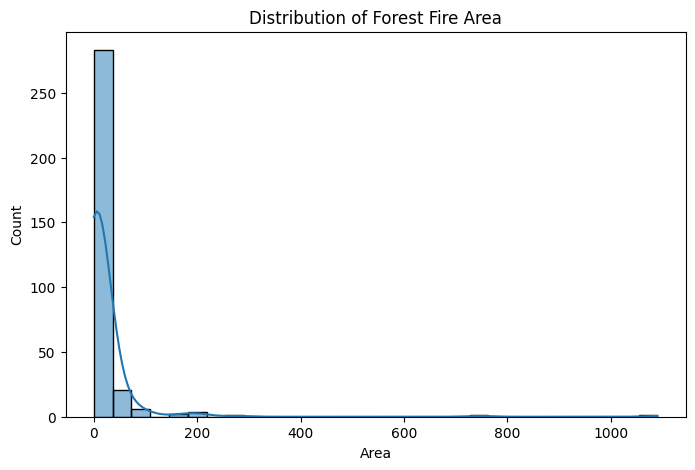

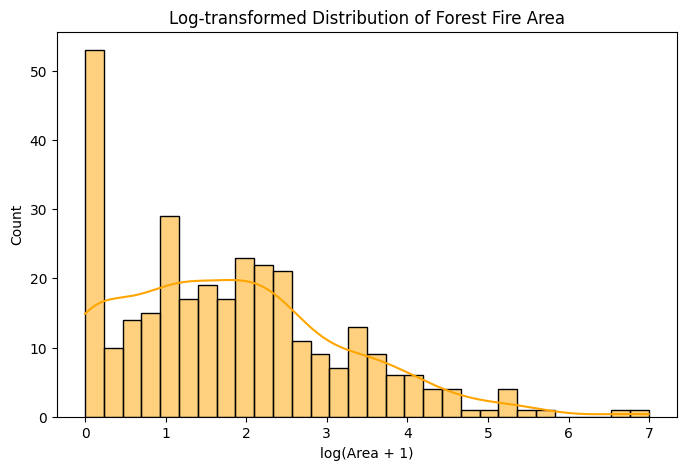

In [4]:
# Plotting the distribution of the target 'area'
plt.figure(figsize=(8, 5))
sns.histplot(Y['area'], bins=30, kde=True)
plt.title('Distribution of Forest Fire Area')
plt.xlabel('Area')
plt.show()

#plot the log-transformed target
plt.figure(figsize=(8, 5))
sns.histplot(np.log1p(Y['area']), bins=30, kde=True, color='orange')
plt.title('Log-transformed Distribution of Forest Fire Area')
plt.xlabel('log(Area + 1)')
plt.show()

In [ ]:
# A helper function to evaluate models
def evaluate_model(model, X_test, y_test_log):
    # Predict in log-space then revert transformation
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test_log)
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f'RMSE: {rmse:.3f}')
    print(f'MAE: {mae:.3f}')
    print(f'R²: {r2:.3f}')
    return y_pred

#Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train_log)
print("Linear Regression Performance:")
lin_y_pred = evaluate_model(lin_reg, X_test, y_test_log)

#Ridge Regression (regularized linear model)
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train_log)
print("\nRidge Regression Performance:")
ridge_y_pred = evaluate_model(ridge, X_test, y_test_log)

#Lasso Regression 
ridge = Lasso(alpha=0.1)
ridge.fit(X_train, y_train_log)
print("\nLasso Regression Performance:")
ridge_y_pred = evaluate_model(ridge, X_test, y_test_log)

Linear Regression Performance:
RMSE: 94.160
MAE: 21.230
R²: -0.032

Ridge Regression Performance:
RMSE: 94.161
MAE: 21.230
R²: -0.032


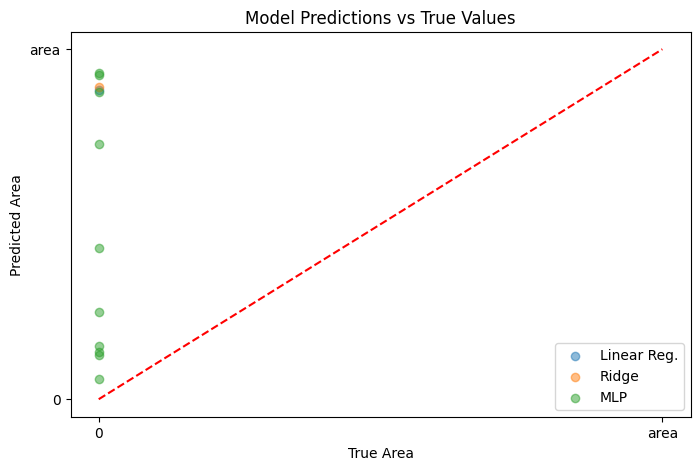

In [23]:
plt.figure(figsize=(8, 5))
plt.scatter(np.expm1(y_test_log), lin_y_pred, alpha=0.5, label='Linear Reg.')
plt.scatter(np.expm1(y_test_log), ridge_y_pred, alpha=0.5, label='Ridge')
plt.scatter(np.expm1(y_test_log), mlp_y_pred, alpha=0.5, label='MLP')
plt.plot([0, max(np.expm1(y_test_log))], [0, max(np.expm1(y_test_log))], 'r--')
plt.xlabel('True Area')
plt.ylabel('Predicted Area')
plt.legend()
plt.title('Model Predictions vs True Values')
plt.show()


In [31]:
#LINEAR REGRESSION

#Train the model by fitting it to the training data
lr = LinearRegression()
lr = lr.fit(X_train, y_train)

lr.coef_

#Test the model by predicting the test results
y_pred = lr.predict(X_test)

print("Test set targets:\n", y_test)
print("Test set predictions:\n", y_pred)
print("Test set R^2: {:.2f}".format(lr.score(X_test, y_test)))

Test set targets:
       area
304   0.00
501   0.00
441   1.23
153   1.46
503   1.95
..     ...
167   2.51
275   5.38
509   2.17
513  54.29
320  34.36

[104 rows x 1 columns]
Test set predictions:
 [[ -0.34209606]
 [ 16.33749263]
 [ 31.47058286]
 [  5.70358788]
 [ 11.00568671]
 [  5.19025969]
 [  4.84531202]
 [ 10.18751793]
 [  4.82647247]
 [ -2.39433464]
 [ 13.04726577]
 [ 11.09456048]
 [ 19.01411536]
 [  3.01043913]
 [ 13.35020814]
 [  0.84979056]
 [ -5.00322672]
 [ 13.22669824]
 [ 21.99679947]
 [ 10.21115877]
 [  7.15667312]
 [ 16.41089041]
 [ 11.0789757 ]
 [ 16.73730969]
 [  1.14575642]
 [ 26.67802647]
 [ 14.74834151]
 [ 30.33865299]
 [ 13.85422731]
 [  5.69408107]
 [ 11.89557979]
 [ 19.64294341]
 [  6.60980261]
 [ 14.77259429]
 [ 12.23535083]
 [ 20.49173281]
 [  5.12719224]
 [ 15.35388032]
 [ 15.29692387]
 [  3.19689515]
 [ 28.43416013]
 [  7.98629451]
 [  8.11827131]
 [ 16.42286834]
 [ 19.90541335]
 [ 24.28940236]
 [ -7.61030642]
 [ 12.19170321]
 [ 10.69823491]
 [ 10.54830794]
 [

Number of principal components selected: 8


c:\Python311\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest (with PCA & log transform) Results:
MSE: 12114.60
R² Score: -0.03


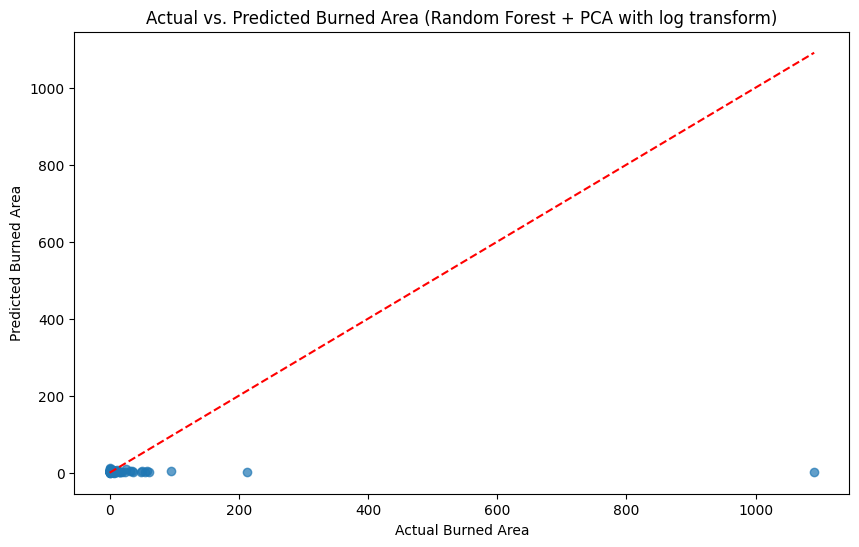

Lasso Regression (with PCA) Results:
MSE: 12097.92
R² Score: -0.03


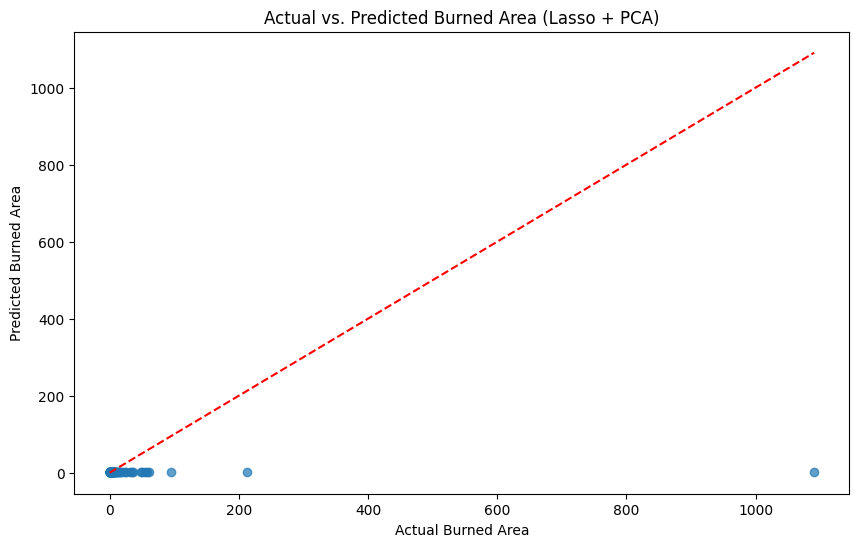

In [36]:
#PCA 
scaler = StandardScaler()

#scale for Lasso
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95)
pca.fit(X_train_scaled)
print("Number of principal components selected:", pca.n_components_)

X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

lasso = Lasso(alpha=0.1)  # Adjust alpha parameter as needed
lasso.fit(X_train_pca, y_train_log)
y_pred_log = lasso.predict(X_test_pca)

##Forest 
rand_forest = RandomForestRegressor(n_estimators=100)  # Adjust alpha parameter as needed
rand_forest.fit(X_train_pca, y_train_log)

y_pred_rand_log = rand_forest.predict(X_test_pca)

# Transform predictions back to the original "area" scale
y_pred_rand = np.expm1(y_pred_rand_log)  # equivalent to exp(predicted_log) - 1

# ===============================
# 4. Evaluate the Model
# ===============================
r2 = r2_score(y_test, y_pred_rand)
mse = mean_squared_error(y_test, y_pred_rand)

print("Random Forest (with PCA & log transform) Results:")
print(f"MSE: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# ===============================
# 5. Visualize Actual vs. Predicted Values
# ===============================
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rand, alpha=0.7)
plt.xlabel('Actual Burned Area')
plt.ylabel('Predicted Burned Area')
plt.title('Actual vs. Predicted Burned Area (Random Forest + PCA with log transform)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line indicating perfect predictions
plt.show()
############
# Transform the predictions back to the original "area" scale
y_pred = np.expm1(y_pred_log)  # y_pred = exp(predicted_log) - 1

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Lasso Regression (with PCA) Results:")
print(f"MSE: {mse:.2f}")
print(f"R² Score: {r2:.2f}")



plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual Burned Area')
plt.ylabel('Predicted Burned Area')
plt.title('Actual vs. Predicted Burned Area (Lasso + PCA)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line for perfect predictions
plt.show()

c:\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


ValueError: X has 1 features, but LinearRegression is expecting 10 features as input.

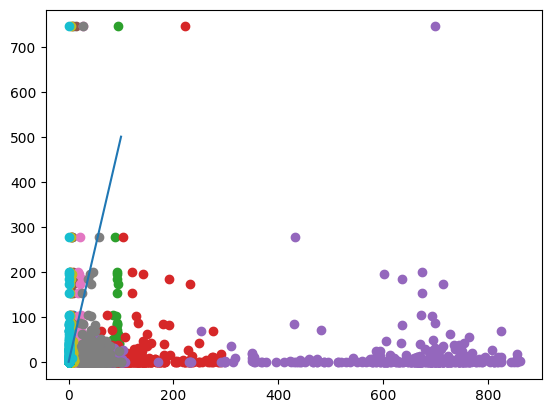

In [10]:
plt.plot(X_train, y_train, 'o')
line = np.linspace(0, 100, 1000).reshape(-1, 1)
plt.plot(line, 5 * line + 1.5)
plt.plot(line, lr.predict(line))
plt.xlabel("Feature")
plt.ylabel("Target")

ValueError: x and y must be the same size

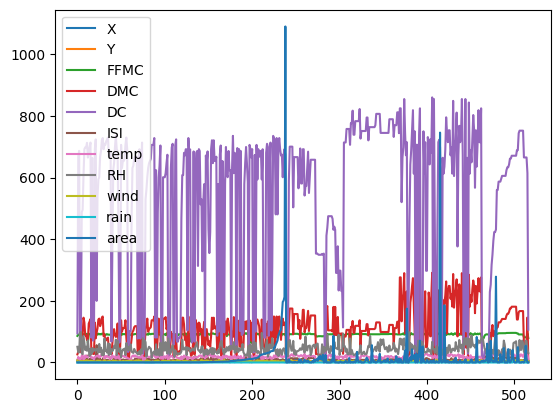

In [ ]:
forest_fires.plot()
plt.scatter(X_train, y_train)
plt.title("Line Plot of All Features")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend(loc="upper right")
plt.show()

In [ ]:
plt.plot(forest_fires.index, forest_fires['temperature'], label='Temperature')
plt.plot(forest_fires.index, forest_fires['humidity'], label='Humidity')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Temperature vs Humidity')
plt.legend()
plt.show()

KeyError: 'temperature'

In [ ]:
def extend(v) :
    ve = np.ones(len(v) + 1)
    ve[1:] = v
    return ve

In [ ]:
def multiple_linear_regression(X, Y) :
    assert len(X) == len(Y)
    Xe = np.array([extend(v) for v in X])
    first=np.transpose(Xe)
    first=np.matmul(first,Xe)
    first=np.linalg.inv(first)
    first=np.matmul(first,np.transpose(Xe))
    print(first.shape)
    theta=np.matmul(first,Y)
    print(Y.shape)
    print(theta.shape)
    return lambda x : np.matmul(theta,extend(x))

In [ ]:
mlr = multiple_linear_regression(X_train, y_train)

ValueError: could not convert string to float: 'X'